In [1]:
#!pip install facenet_pytorch

In [32]:
import os           

# Check if string is appropriate youtube link
import re
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import face_recognition

import seaborn as sns
import plotly.express as px

SAVE_VIDEO = True
SHOW_PROMPT = False

# DEBUG-Mode stops operations when max_emotions were detected and also prints a short summary
DEBUG = True
if DEBUG:
    import time
    debug_params = {
        'max_emotions' : 100
    }

In [33]:
def get_path(kind):
    if kind == "youtube":
        return "https://www.youtube.com/watch?v=vtT78TfDfXU"                   # Random video
        #return 'https://www.youtube.com/watch?v=embYkODkzcs'                 # 7 basic emotions
        #return 'https://www.youtube.com/watch?v=m70UInZKJjU'                    # Two persons
    if kind == "local":
        # adjust individually
        return '/Users/steve/Neue_Fische/face_demo/vids/Video_One_output.mp4'
    if kind == "error_on_purpose":
        return "wrongful path"
    else:
        raise ValueError(f"Passed Argument kind must bei in ['youtube', 'local', 'error_on_purpose'] but was: {kind}")

def youtube_stream(yt_link):
    # Load the video from YouTube
    yt_video = YouTube(yt_link)
    stream = yt_video.streams.get_highest_resolution()    #or highest resolution?
    stream.download()
    return cv2.VideoCapture(stream.default_filename)

def local_stream(local_path):
    return cv2.VideoCapture(local_path)

def get_stream(path):
    # Check if the string is a YouTube link
    if re.match(r'(https?://)?(www\.)?(youtube\.com|youtu\.?be)/.+$', path):
        return youtube_stream(path)
    # Check if the string is a local path
    elif os.path.isfile(path):
        return local_stream(path)
    # Check if the path is a local file path but no file is found
    elif os.path.exists(path):
        raise ValueError(f"File not found at path: {path}")
    # If it's neither a local path nor a YouTube link, raise an error
    else:
        raise ValueError("The input string is neither a local path nor a YouTube link.")
    
def load_emotion_classifier():
    return load_model("../models/emotion_model.hdf5", compile=False)

def preprocess_face(face, input_face_size):
    face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)  # Convert the face to grayscale
    face = cv2.resize(face, (input_face_size[1], input_face_size[0]))  # Swap width and height
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=-1)  # Add an additional dimension for grayscale channel
    face = np.expand_dims(face, axis=0)
    return face

def print_debug_report(operating_results):    
    print(f'{operating_results["analyzed_emotions"]} faces found in {operating_results["analyzed_frames"]} frames.')
    print(f'{operating_results["frames_without_faces"]} frames had no face detected ({operating_results["frames_without_faces_ratio"]}%).')
    print(f'Stopped operations after around {operating_results["processed_video_time"]} seconds into the video.')
    print(f'Execution time: {operating_results["runtime"]} seconds, processing (roughly) {round(operating_results["processed_video_time"]/operating_results["runtime"],2)} seconds of video per second of execution')

def initialize_face_detector(model_type):
    if model_type == 'haarcascade':
        return cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    elif model_type == "MTCNN":
        return MTCNN(keep_all=True, post_process=False, margin=20)
    else:
        raise ValueError("By now, only Haarcascade is implemented.")

def preprocess_frame_for_face_detection_haarcascade(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

def preprocess_frame_for_emotion_detection(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def normalize_boxes_mtcnn(boxes):
    """
    Normalize the bounding box coordinates from MTCNN to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        normalized_boxes.append([y_min, y_max, x_min, x_max])
    return np.array(normalized_boxes)

def normalize_boxes_cv2(boxes):
    """
    Normalize the bounding box coordinates from OpenCV's format to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x, y, w, h = box
        normalized_boxes.append([y, y+h, x, x+w])
    return np.array(normalized_boxes)

def detect_faces(frame, face_detector, model_type = 'haarcascade'):
    if model_type == 'haarcascade':
        frame_pp = preprocess_frame_for_face_detection_haarcascade(frame)
        boxes =  face_detector.detectMultiScale(frame_pp, scaleFactor = 1.3, minNeighbors = 3)
        if boxes is None:
            return None
        else:
            return normalize_boxes_cv2(boxes)
    elif model_type == "MTCNN":
        # No preprocessing needed for VideoCapture Frame
        boxes, _ = face_detector.detect(frame)
        if boxes is None:
            return None
        else:
            return normalize_boxes_mtcnn(boxes)
        #return [(x['box'][1], x['box'][0] + x['box'][2], x['box'][1] + x['box'][3], x['box'][0]) for x in bounding_boxes]
    #elif model_type == "fast_MTCNN"
    # https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
    else:
        raise ValueError("By now, only Haarcascade is implemented.")
    
def get_ordered_emotions():
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def emotions_probability(frame, face_location, emotion_classifier):
    frame_pp = preprocess_frame_for_emotion_detection(frame)
    y_min, y_max, x_min, x_max = face_location
    face = frame_pp[y_min:y_max, x_min:x_max]
    face = preprocess_face(face, input_face_size=emotion_classifier.input_shape[1:3])
    prob = emotion_classifier.predict(face)[0]  # check for underscore
    return prob

def output_video(video, filename):
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    return cv2.VideoWriter(filename, fourcc, 10, (width,height))

def get_overview_df(emotions, frame_info, frame_info_cols):
    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    return df_all_info

def get_plottable_df(emotions, frame_info, frame_info_cols):

    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    df_plotting = pd.melt(df_all_info, id_vars=frame_info_cols, value_vars=get_ordered_emotions(), var_name='emotion', value_name='probability')
    return df_plotting

In [34]:
if DEBUG: start_time = time.time()

# Define video path
path = get_path('youtube')

# Set the number of frames to skip
frames_to_skip = 1

# Get Video as cv2.VideoCapture
# Can access Youtube Video or local file
video = get_stream(path)

# Initialize writer to save the annotated video
if SAVE_VIDEO: writer = output_video(video, filename='outputs/Output_video.mp4')

# Initialize the face detection model
#model_type = "MTCNN"
model_type = "haarcascade"
face_detector = initialize_face_detector(model_type)


# Initialize the emotion detection model
emotion_classifier = load_emotion_classifier()

# Initialize lists to store emotions and frame_info
emotions = []
frame_info = []

# Initialize counters
frames_without_faces_counter = 0
individual_id_counter = 0
face_embeddings = {}


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [35]:
# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame counter
    current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Skip frames based on the frames_to_skip parameter
    if current_frame_nr % frames_to_skip != 0:
        continue
    
    # Find faces within a frame and return list of coordinates of bounding boxes
    face_locations = detect_faces(frame, face_detector, model_type)

    # Check if any faces were found
    if face_locations is None:
        frames_without_faces_counter += 1
        continue

    for i, face_location in enumerate(face_locations):
        prob = emotions_probability(frame, face_location, emotion_classifier)
        emotions.append(prob)
        
        # Add the current timestamp (milliseconds) and probabilities of emotions to the frame_description list
        # current implementation to prepare for tuple-wise operation, change frame later to character_nr
        
        frame_info.append(
            (round(video.get(cv2.CAP_PROP_POS_MSEC) / 1000, 2),
                current_frame_nr
                )
        )    

        max_emotion, max_prob = np.argmax(prob), np.max(prob)
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        emotion_text = emotion_labels[max_emotion]

        for (y_min, y_max, x_min, x_max) in face_locations:
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, f"Prob: {max_prob:.1%}", (x_min, y_max + 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            cv2.putText(frame, f"{emotion_text}", (x_min, y_max + 30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            cv2.putText(frame, f"Frame {current_frame_nr}", (30,40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            
    if SAVE_VIDEO: writer.write(frame)
    
    if SHOW_PROMPT:
        cv2.imshow("Faces found", frame)

        # Wait for Esc key to stop
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    if DEBUG:
        # For debugging reasons, we stop when we have 1000 emotion values
        if len(emotions) > debug_params['max_emotions']:
            break

# Release the video and close the window
video.release()

if SAVE_VIDEO: writer.release()

# De-allocate any associated memory usage
cv2.destroyAllWindows()

if DEBUG: end_time = time.time()

if DEBUG:
    # When in DEBUG-mode, print some statistics about the faces and emotions detected
    operating_results = {'analyzed_emotions': len(emotions),
                         'analyzed_frames':frame_info[-1][1], 
                         'frames_without_faces':frames_without_faces_counter,
                         'frames_without_faces_ratio': round(100*frames_without_faces_counter/frame_info[-1][1],2),
                         'processed_video_time': round(frame_info[-1][0] / 1000 ,2),
                         'runtime': round(end_time - start_time,2)}
    
    print_debug_report(operating_results)
    
df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

2023-03-21 10:37:27.367809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step
101 faces found in 102 frames.
0 frames had no face detected (0.0%).
Stopped operations after around 0.0 seconds into the video.
Execution time: 10.55 seconds, processing (roughly) 0.0 seconds of video per second of execution


In [5]:
df_plotting

,pos_sec,frame,emotion,probability
0,0.00,1,Angry,0.004754
1,0.04,2,Angry,0.006010
2,0.08,3,Angry,0.003043
3,0.12,4,Angry,0.005749
4,0.17,5,Angry,0.004518
...,...,...,...,...
8248,74.17,1781,Neutral,0.842472
8249,74.21,1782,Neutral,0.765882
8250,74.25,1783,Neutral,0.729591
8251,74.29,1784,Neutral,0.715845


In [ ]:
"""
        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
    for i, face_landmark in enumerate(face_landmarks):
        if not face_landmark:
            continue

        if i < len(face_locations):
            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]
        else:
            continue            
        current_individual_ids = []

        # Compare the current face encoding with the existing face embeddings
        for individual_id, individual_face_encoding in face_embeddings.items():
            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:
                current_individual_ids.append(individual_id)
                break
        else:
            individual_id_counter += 1
            current_individual_ids.append(individual_id_counter)
            face_embeddings[individual_id_counter] = face_encoding
    """

In [6]:
df_overview  = get_overview_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

In [7]:
df_overview.head(30)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame
0,0.004754,1.568966e-05,0.006978,0.937312,0.003946,0.004224,0.042770,0.00,1
1,0.006010,1.628348e-05,0.027883,0.762690,0.009061,0.012228,0.182112,0.04,2
2,0.003043,1.090113e-05,0.014361,0.899901,0.004817,0.005181,0.072687,0.08,3
3,0.005749,4.555533e-05,0.030709,0.862432,0.006436,0.016714,0.077915,0.12,4
4,0.004518,2.951487e-05,0.025148,0.852247,0.008460,0.004969,0.104629,0.17,5
5,0.014398,1.086464e-04,0.064432,0.770944,0.033075,0.010573,0.106470,0.21,6
6,0.003394,1.460315e-05,0.008064,0.937469,0.002114,0.002497,0.046448,0.25,7
7,0.022420,8.548751e-05,0.058179,0.734867,0.018430,0.010781,0.155238,0.29,8
8,0.015442,2.231497e-05,0.098677,0.804541,0.007662,0.023076,0.050580,0.33,9
9,0.005769,1.211875e-05,0.048737,0.869642,0.006872,0.006617,0.062350,0.38,10


In [6]:
len(face_locations)

1

In [4]:
face_locations

[(36, 112, 79, 69)]

In [18]:
df_overview.head(50)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame,character_id
0,0.021273,0.000087,0.008457,0.938794,0.007456,0.000201,0.023732,0.00,1,1
1,0.017754,0.000111,0.008417,0.942245,0.006612,0.000167,0.024694,0.08,2,1
2,0.021975,0.000197,0.009557,0.930175,0.008477,0.000174,0.029444,0.17,3,1
3,0.005914,0.000027,0.002789,0.975268,0.002386,0.000113,0.013503,0.25,4,1
4,0.004781,0.000058,0.003186,0.970666,0.004590,0.000155,0.016563,0.33,5,1
5,0.017244,0.000050,0.021483,0.928890,0.018052,0.000376,0.013905,0.42,6,1
6,0.060583,0.000082,0.044794,0.850776,0.023353,0.000733,0.019679,0.50,7,1
7,0.025617,0.000052,0.043961,0.873902,0.023845,0.001998,0.030627,0.58,8,1
8,0.023427,0.000047,0.018805,0.926211,0.010138,0.000540,0.020832,0.67,9,1
9,0.008736,0.000044,0.011812,0.965763,0.005509,0.000195,0.007942,0.75,10,1


In [14]:
#df_10th = df_plotting[df_plotting["frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_plotting, x="pos_sec", y='probability', color = 'emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [15]:
#df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_plotting, x="pos_sec", y='probability', color = 'emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

<Axes: xlabel='pos_sec', ylabel='probability'>

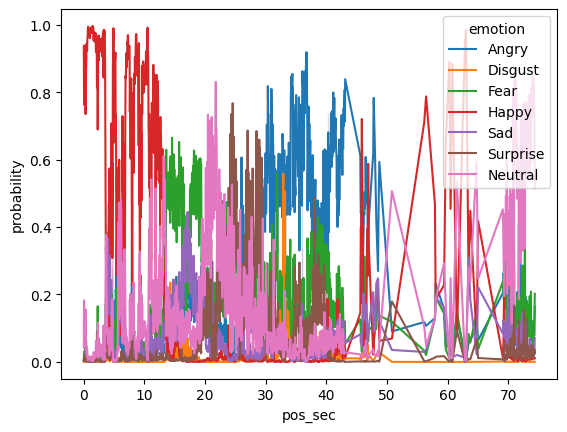

In [16]:
sns.lineplot(data = df_plotting, x = 'pos_sec', y='probability', hue = 'emotion')

In [9]:
fig = px.area(df_plotting, x="pos_sec", y="probability", color="emotion")
fig.show()

In [12]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [13]:
fig = px.area(df, x="pos_sec", y="moving_avg", color="emotion")
fig.show()

# I Adjusted plots until here

### Still Open
* Periods with no people are by now interlinked - so we have straight in the original data and valleys forming in the rolling mean.
* Tha Barcharts show quite well when multiple people com into play - but by now, their values are summed up. If we can get Character Recognition to work, that will be great - if not, at least we can try to reduce it down to one person per frame, but there's no guarantee that we always get the same person.
* With objects and classes we could structure the code even better
* I have the feeling from my videos that the performance is not super good right - maybe we achieve to get better results somehow.
* Much faster on youtube video data looking at Video_seconds analyzed per processing second.

#### After Dinner the youtube integration stopped working, I can't see why!

<Axes: xlabel='Frame', ylabel='moving_avg'>

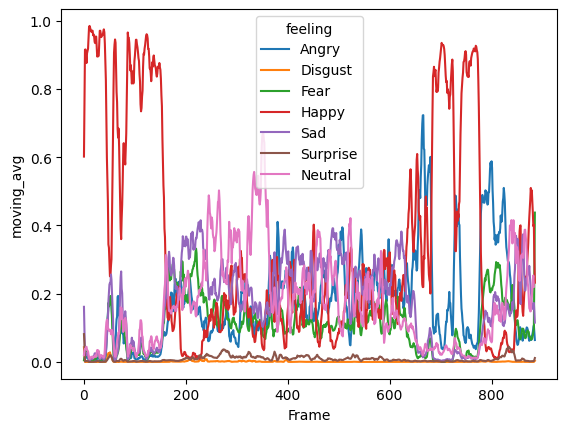

In [71]:
sns.lineplot(data = df_plotting, x = 'Frame', y='moving_avg', hue = 'feeling')

In [87]:
df_plotting

,Frame,feeling,probability,moving_avg
0,0,Angry,0.005274,NaN
1,1,Angry,0.010392,NaN
2,2,Angry,0.008759,NaN
3,3,Angry,0.028516,NaN
4,4,Angry,0.004002,NaN
...,...,...,...,...
6197,881,Neutral,0.185039,0.202502
6198,882,Neutral,0.252427,NaN
6199,883,Neutral,0.252427,NaN
6200,884,Neutral,0.240728,NaN


In [90]:
max_prob_rows = df_plotting.groupby('Frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()
max_prob_df


,Frame,feeling,probability,moving_avg
2658,0,Happy,0.955532,0.505082
2659,1,Happy,0.935133,0.593292
2660,2,Happy,0.923429,0.665813
2661,3,Happy,0.822713,0.738803
2662,4,Happy,0.938086,0.825939
...,...,...,...,...
3539,881,Happy,0.507732,0.446257
3540,882,Happy,0.367060,0.402680
3541,883,Happy,0.367060,0.351637
3542,884,Happy,0.399157,0.299369


In [49]:
sns.barplot(data = max_prob_df, x = 'Frame', y='probability', hue='feeling')

NameError: name 'max_prob_df' is not defined

In [145]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [28]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['Frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('Frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['Frame', 'feeling'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('Frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='Frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='Frame', 
    y='probability_normalized', 
    color='feeling', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Feeling Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [29]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [30]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [31]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [150]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

In [151]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [152]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.